In [7]:
from astropy.io import fits
import glob, os
import numpy as np
import matplotlib.pyplot as plt
from exorim.operators import NDFTM, Baselines, closure_phase_operator, closure_fourier_matrices, redundant_phase_closure_operator, closure_baselines_projectors
from exorim.physical_model import JWST_NIRISS_MASK
from exorim.definitions import rad2mas
from scipy.signal.windows import hann, general_gaussian
from pprint import pprint
from scipy.linalg import cholesky
# np.set_printoptions(edgeitems=10)
# np.core.arrayprint._line_width = 180

In [8]:
datapath = "../data/psf/"
psfs = []
for file in glob.glob(datapath + "jwst_F380M_2_psf_OPD[0-9]*"):
    psfs.append(fits.open(file))

In [4]:
wavelength = []#psfs[-1][0].header["WAVELEN"]
for i in range(len(psfs)):
    wavelength.append(psfs[i][0].header["WAVELEN"])
wavelength = np.array(wavelength)
platescale = rad2mas(psfs[-1][0].header["PIXELSCL"] * np.pi / 180 / 3600)
difflim = psfs[-1][0].header["DIFFLMT"]
pixels =  psfs[-1][0].data.shape[0]
coords = JWST_NIRISS_MASK.numpy()
coords[:, 1] = -coords[:, 1] # flip y axis
baselines = Baselines(coords)
uv = baselines.UVC
cpo = closure_phase_operator(baselines)
# cpo = redundant_phase_closure_operator(baselines)
ndftm = NDFTM(uv, wavelength.mean(), pixels, platescale)
A1, A2, A3 = closure_fourier_matrices(ndftm, cpo)
V1, V2, V3 = closure_baselines_projectors(cpo)

In [5]:
wavelength.mean()

3.826025395053875e-06

In [6]:
platescale / 1000

0.032799999999999996

In [7]:
difflim / platescale * 1000

3.5441390323915005

In [8]:
# plt.title(f"{wavelength.mean()}")
# plt.hist(wavelength, bins=10);
# wavelength.mean()

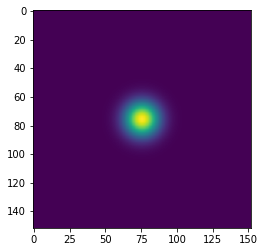

In [9]:
# h = hann(pixels)
h = general_gaussian(pixels, p=1, sig=pixels/18)
# h = np.ones(pixels)
h = np.outer(h, h)
plt.imshow(h)

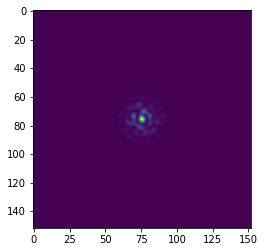

In [10]:
plt.imshow(psfs[0][0].data * h)

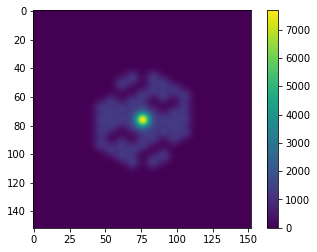

In [12]:
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(psfs[0][0].data * h * 152**2))))
plt.colorbar()

In [649]:
central_power = np.abs(np.fft.fft2(psfs[0][0].data)[0, 0])**2
central_power

1.0

In [16]:
pistons = []
bispectra = []
for i in range(len(psfs)):
    pistons.append(ndftm @ np.ravel(psfs[i][0].data * h))
    v1 = A1 @ np.ravel(psfs[i][0].data * h)
    v2 = A2 @ np.ravel(psfs[i][0].data * h)
    v3 = A3 @ np.ravel(psfs[i][0].data * h)
    bispectra.append(v1 * np.conjugate(v2) * v3)
pistons = np.array(pistons)
bispectra = np.array(bispectra)

In [17]:
# derive noise statistics from psf realizations

In [18]:
(np.abs(pistons).std(axis=0))#.mean()

array([0.00079326, 0.0003999 , 0.00025881, 0.00084522, 0.00018091,
       0.00022733, 0.000813  , 0.00076525, 0.00054603, 0.00050279,
       0.00062676, 0.00063966, 0.00025679, 0.0002882 , 0.00035917,
       0.00109878, 0.00022232, 0.00036921, 0.00026031, 0.00037381,
       0.00045959])

In [653]:
pistons.shape

(420, 21)

In [654]:
np.angle(pistons).std(axis=0)

array([0.12238841, 0.12635237, 0.13324963, 0.11571664, 0.18878218,
       0.09508242, 0.11305546, 0.19825309, 0.14017575, 0.17193708,
       0.11222487, 0.22860799, 0.09670052, 0.15238761, 0.09083636,
       0.15900887, 0.22601684, 0.17360627, 0.149954  , 0.08070016,
       0.09867783])

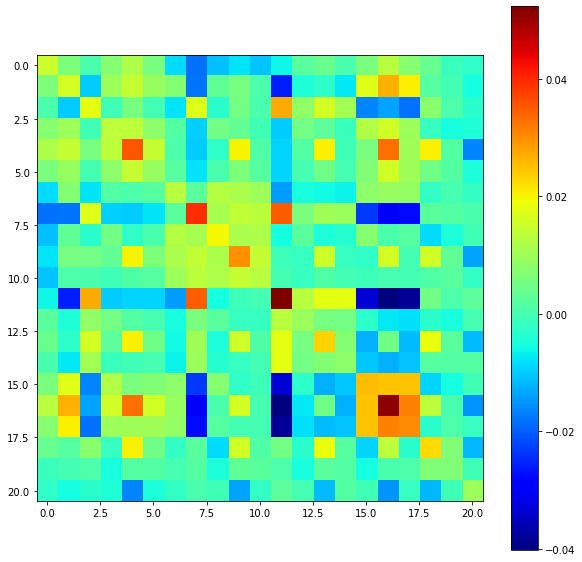

In [655]:
plt.figure(figsize=(10, 10))
plt.imshow(np.cov(np.angle(pistons).T), cmap="jet")
plt.colorbar()

In [656]:
(np.abs(pistons)).std(axis=0)

array([0.00079326, 0.0003999 , 0.00025881, 0.00084522, 0.00018091,
       0.00022733, 0.000813  , 0.00076525, 0.00054603, 0.00050279,
       0.00062676, 0.00063966, 0.00025679, 0.0002882 , 0.00035917,
       0.00109878, 0.00022232, 0.00036921, 0.00026031, 0.00037381,
       0.00045959])

In [657]:
(np.angle(bispectra).mean(axis=0) * 180 / np.pi)

array([ 1.7945195 ,  1.75242465,  0.59631737,  2.24019157,  0.72602101,
       -0.16801198, -1.65395847,  0.60952877, -0.65002689,  0.46820739,
       -1.00263691, -1.3316854 ,  1.67027838,  0.31550701, -1.41419281])

In [658]:
np.angle(bispectra).std(axis=0) / np.sqrt(3) #* 180 / np.pi

array([0.01632955, 0.01799486, 0.0203295 , 0.0217675 , 0.01067421,
       0.00629036, 0.01042577, 0.00864352, 0.00913663, 0.01313433,
       0.01296806, 0.01080464, 0.01314868, 0.00519873, 0.02534165])

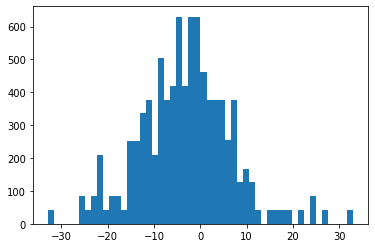

In [659]:
plt.hist(np.ravel(np.angle(pistons)) * 180 / np.pi, bins=50);
# plt.xlim(-5, 5)

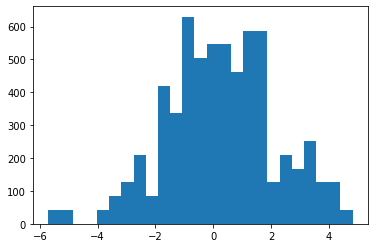

In [660]:
plt.hist(np.ravel(np.angle(bispectra)) * 180 / np.pi, bins=25);
# plt.xlim(-5, 5)

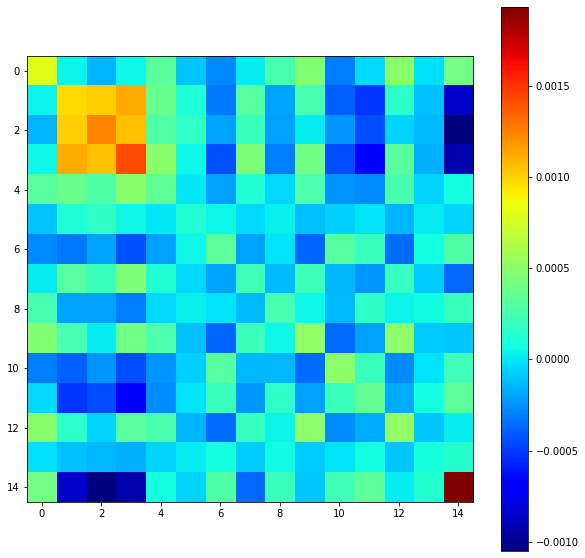

In [661]:
plt.figure(figsize=(10, 10))
plt.imshow(np.cov(np.angle(bispectra).T), cmap="jet")
plt.colorbar()

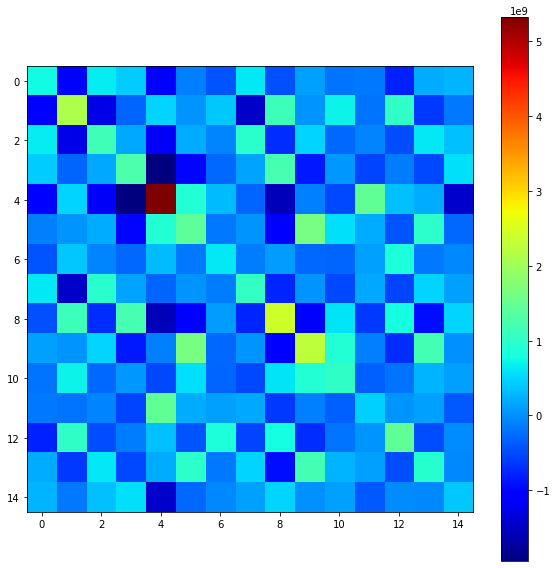

In [519]:
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.inv(np.cov(np.angle(bispectra).T)), cmap="jet")
plt.colorbar()

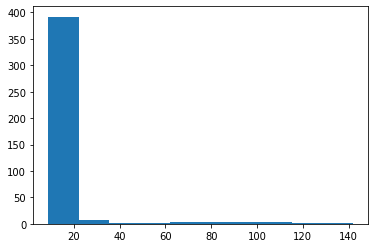

In [477]:
xi = np.angle(bispectra) - np.angle(bispectra).mean(axis=0)
plt.hist(np.einsum("...i, ij, ...j -> ...", xi, np.linalg.inv(np.cov(np.angle(bispectra).T)), xi));

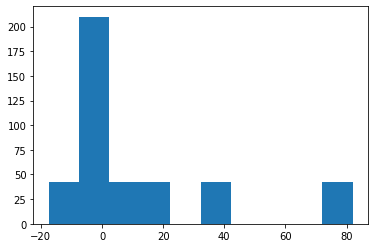

In [478]:
plt.hist(np.einsum("...i, ...j -> ...", np.angle(bispectra), np.angle(bispectra) / np.var(np.angle(bispectra), axis=0)));

In [520]:
# estimated intrinsic piston noise (baseline noise)
std_piston_angle = np.ravel(np.angle(bispectra)).std() / np.sqrt(3)
std_piston_angle#*180 / np.pi

0.01913442272077396

In [685]:
Labs = cholesky(np.cov(np.abs(pistons).T))
Lphase = cholesky(np.cov(np.angle(pistons).T)) #/ np.sqrt(3)

In [686]:
# simulate data0, 21))) * \
#     np.exp(1j * np.random.normal(loc=0, scale=std_piston_angl
gain_amp = np.abs(np.einsum("ij, ...j -> ...i", Labs.T, np.random.normal(size=(200, 21))))
gain_phase = np.exp(1j * np.einsum("ij, ...j -> ...i", Lphase.T, np.random.normal(size=(200, 21))))
gain = gain_amp * gain_phase
# gain = np.abs(np.random.normal(loc=1, scale=0.0645, size=(200, 21))) * \
#     np.exp(1j * np.random.normal(loc=np.angle(pistons).mean(axis=0), scale=std_piston_angle, size=(200, 21)))

v1 = np.einsum("ij, ...j -> ...i", V1, gain)
v2 = np.einsum("ij, ...j -> ...i", V2, gain)
v3 = np.einsum("ij, ...j -> ...i", V3, gain)
B = v1 * np.conjugate(v2) * v3

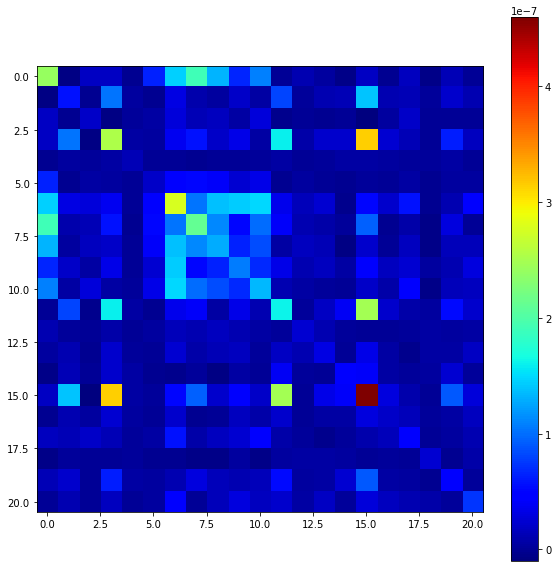

In [687]:
plt.figure(figsize=(10, 10))
plt.imshow(np.cov(gain_amp.T), cmap="jet")
plt.colorbar()

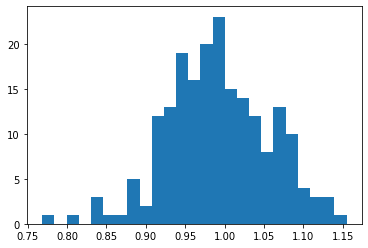

In [688]:
plt.hist(np.ravel(np.abs(V)[:, 2]), bins=25);

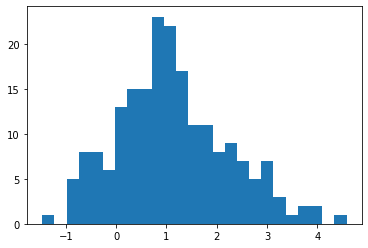

In [689]:
plt.hist(np.ravel(np.angle(V)[:, 20]) * 180 / np.pi, bins=25);

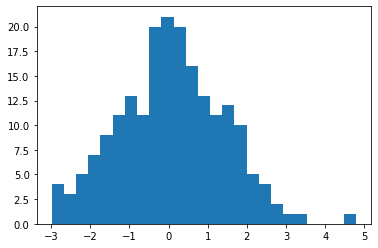

In [690]:
plt.hist(np.ravel(np.angle(B)[:, 10]) * 180 / np.pi, bins=25);

In [684]:
((np.angle(B)[:, 10]) * 180 / np.pi).std()

0.725157219031002

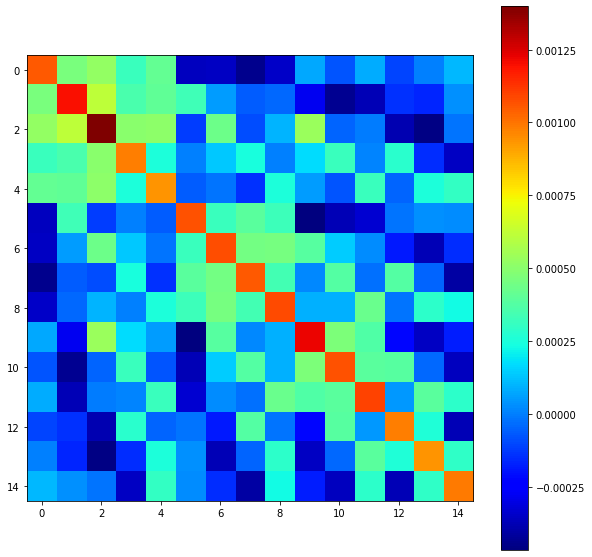

In [556]:
plt.figure(figsize=(10, 10))
plt.imshow(np.cov(np.angle(B).T), cmap="jet")
plt.colorbar()

In [698]:
# save cholesky operators of pistons to reproduce the pistons in simulation
with open("../exorim/interferometry/models/cholesky_gain_amp.npy", "wb") as file:
    np.save(file, Labs)
    
with open("../exorim/interferometry/models/cholesky_gain_phase.npy", "wb") as file:
    np.save(file, Lphase)

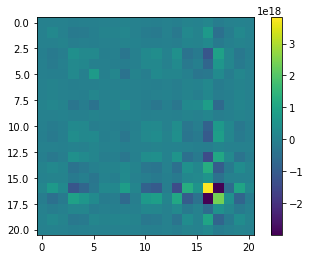

In [708]:
# save covariance matrix of power spectra and closure phases for likelihood
# with open("../exorim/interferometry/models/power_spectra_cov_inverse.npy", "wb") as file
plt.imshow(np.linalg.inv(np.cov((np.abs(pistons)**2).T)))
plt.colorbar()